# G3D Fitting

v1: initial try

In [1]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
sp.init_printing()

x = sp.symbols('x')
class FitG3D:
    def __init__(self, sympy_function, args, args0, name):
        self.name = name
        # G3D
        self.spG3D = sympy_function 
        self.npG3D = sp.lambdify([x, *args], sympy_function(x, *args), 'numpy') 

        # g3D 
        self.spg3D = lambda x, *args: sp.diff(sympy_function(x, *args), x)  
        self.npg3D = sp.lambdify([x, *args], self.spg3D(x,*args), 'numpy')

        # aPSF3D
        self.spaPSF3D = lambda x, *args: self.spg3D(x, *args) / x**2
        self.npaPSF3D = sp.lambdify([x, *args], self.spaPSF3D(x,*args), 'numpy')
        

        self.params = args  # first argument is x
        self.initial_params = args0

        self.fitted_params = None
        self.residual = None
        self.chi2 = None

    def fit(self, xdata, ydata):
        popt, pcov = curve_fit(self.npG3D, xdata, ydata, p0=self.initial_params)
        perr = np.sqrt(np.diag(pcov))
        self.fitted_params = popt

        self.residual = np.sqrt(np.sum((self.npG3D(xdata, *popt) - ydata)**2))
        self.chi2 = (ydata - self.npG3D(xdata, *popt))**2 / self.npG3D(xdata, *popt)
        self.chi2[self.chi2 == np.inf] = 0
        self.chi2 = np.sum(self.chi2)

        return self.residual, self.chi2
    
    def get_params(self, redon=2):
        params_rounded = [round(p, redon) for p in self.fitted_params]
        dict_params = dict(zip(self.params, params_rounded))
        return params_rounded, dict_params
    
    def show_info(self, redon=2):
        print(f'Fit {self.name}:')
        params_rounded, dict_params = self.get_params(redon)
        expr_rounded = self.spG3D(x, *params_rounded)
        display(self.spG3D(x, *self.params))
        display(expr_rounded)
        print(f"{dict_params=}")
        print(f"{self.residual=:.4f}\t{self.chi2=:.4f}")
        print() 
    
    def get_G3D(self):
        G3D = self.spG3D(x, *self.fitted_params)
        G3D = sp.lambdify(x, G3D, 'numpy')
        return G3D

    def get_g3D(self):
        g3D = self.spg3D(x, *self.fitted_params)
        g3D = sp.lambdify(x, g3D, 'numpy')
        return g3D
    
    def get_aPSF3D(self):
        aPSF3D = self.spaPSF3D(x, *self.fitted_params)
        aPSF3D = sp.lambdify(x, aPSF3D, 'numpy')
        return aPSF3D

def load_sample(input_file):
    sample = np.loadtxt(input_file)
    if sample.ndim == 1:
        pass
    elif sample.ndim == 2:
        sample = np.sqrt(np.sum(sample**2, axis=1))
    else:
        print("WTF")
    return sample
    
def load_G3D(input_file):
    sample = load_sample(input_file)

    s = len(sample)
    sample_sorted = np.sort(sample)
    sample_G3D_sort = np.arange(1,s+1)/s
    return sample_sorted, sample_G3D_sort

def load_g3D(input_file, bin_size=0.5):
    sample = load_sample(input_file)
        
    bins = np.arange(0, sample.max() + bin_size, bin_size)
    sample_histo, step = np.histogram(sample, bins=bins, density=True)  #g3D
    sample_rp = step[:-1] + np.diff(step)/2
    sample_histo = sample_histo / sample_histo.sum()
    return sample_rp, sample_histo

def load_aPSF3D(input_file, bin_size=0.5):
    sample_rp, sample_histo = load_g3D(input_file, bin_size)   # bin_size in mm
    sample_aPSF3D = sample_histo / sample_rp**2
    sample_aPSF3D = sample_aPSF3D / sample_aPSF3D.sum()
    return sample_rp, sample_aPSF3D


a, b, c, d = sp.symbols('a b c d')
n1, n2, n3, n4 = sp.symbols('n1 n2 n3 n4')


## Test no-histogram method

In [ ]:
material = "Water"
code = "PenEasy2024"
isotope = "F18"
input_file = f"RESULTS/SPC/{material}/{code}_xyz/{isotope}.dat" # in cm
sample_r, sample_G3D = load_G3D(input_file)
sample_r *= 10

# G3D histogram
bs = 0.001      # <<---<< the lower the better (in cm)
data_r, data_g3D = load_g3D(input_file, bin_size=bs) # in cm
data_r *= 10
data_G3D = np.cumsum(data_g3D)


plt.plot(sample_r, sample_G3D, label='G3D w/o histogram')
plt.plot(data_r, data_G3D, label='G3D w/ histogram')
plt.xlabel('r (mm)')
plt.ylabel(r'$G_{3D}$(r)')
plt.title(f'{code} / {material} / {isotope}')
plt.legend()
plt.show()

## Test fitting

In [ ]:
material = "Water"
cfolder = "GATE92_xyz"
isotope = "F18"
bs = 2e-3      # <<---<< the lower the better (in cm)
# Load sample
input_file = f"../PRcomp/RESULTS/SPC/{material}/{code}/{isotope}.dat" # in cm
sample_r, sample_G3D = load_G3D(input_file)
sample_rp, sample_g3D = load_g3D(input_file, bin_size=bs)
sample_rp, sample_aPSF3D = load_aPSF3D(input_file, bin_size=bs)
sample_r *= 10
sample_rp *= 10

# Defining fitting function
args = [a,b,c]
args0 = [1,1,1]
spf = lambda x, a,b,c: 1 - sp.exp(-(a*x + b*x**2  + c*x**4))
fit_func = FitG3D(spf, args, args0, '1 - exp(-(a*x + b*x^2  + c*x^4))')

# Fit
res, chi2 = fit_func.fit(sample_r, sample_G3D)
fit_func.show_info(redon=4)
fit_G3D = fit_func.get_G3D()
fit_g3D = fit_func.get_g3D()
fit_aPSF3D = fit_func.get_aPSF3D()

# Plot
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(sample_r, sample_G3D, label='G3D')
plt.plot(sample_r, fit_G3D(sample_r), 'k--', label='Fit')
# plt.xscale('log')
plt.xlabel('r (mm)')
plt.ylabel(r'$G_{3D}$(r)')
plt.title(f'{code} / {material} / {isotope}')
plt.legend()

plt.subplot(132)
gg = fit_g3D(sample_rp)
gg = gg / gg.sum()
plt.plot(sample_rp, sample_g3D, label='g3D')
plt.plot(sample_rp, gg, 'k--', label='Fit')
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('r (mm)')
plt.ylabel(r'$g_{3D}$(r)')
plt.title(f'{code} / {material} / {isotope}')
plt.legend()

plt.subplot(133)
gg = fit_aPSF3D(sample_rp)
gg = gg / gg.max()
plt.plot(sample_rp, sample_aPSF3D/sample_aPSF3D.max(), label='aPSF3D')
plt.plot(sample_rp, gg, 'k--', label='Fit')
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('r (mm)')
plt.ylabel(r'$aPSF_{3D}$(r)')
plt.title(f'{code} / {material} / {isotope}')
plt.legend()

plt.show()

# Apply G3DF to all results

**********-PHITS_xyz-**********
Lung - C11          	res=1.6222	chi2=44.3959
Lung - F18          	res=1.4351	chi2=16.3353
Lung - Ga68         	res=2.6889	chi2=96.4162
Water - C11         	res=1.6659	chi2=45.8289
Water - N13         	res=0.8089	chi2=14.8382
Water - O15         	res=0.5624	chi2=1.8044
Water - F18         	res=1.4774	chi2=17.2023
Water - Cu64        	res=4.4561	chi2=250.2612
Water - Ga68        	res=2.7630	chi2=101.7630
Water - Rb82        	res=2.1795	chi2=69.3410
Water - I124        	res=5.3732	chi2=321.6264
Bone - C11          	res=1.6176	chi2=42.5993
Bone - F18          	res=1.3556	chi2=14.2880
Bone - Ga68         	res=2.9330	chi2=109.0775


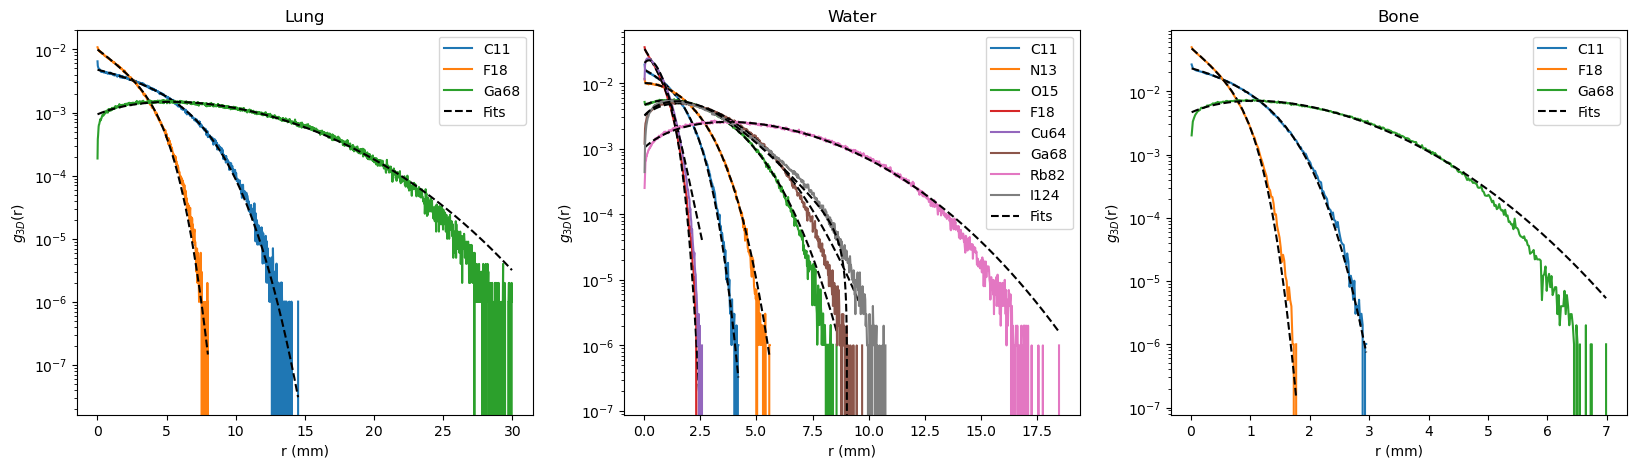

**********-PenEasy2020_xyz-**********
Lung - C11          	res=0.9765	chi2=9.8503
Lung - F18          	res=0.6705	chi2=6.7317
Lung - Ga68         	res=2.8462	chi2=111.2287
Water - C11         	res=0.9490	chi2=8.9458
Water - N13         	res=0.3059	chi2=1.0097
Water - O15         	res=0.8017	chi2=3.9355
Water - F18         	res=0.5968	chi2=5.5833
Water - Cu64        	res=4.9171	chi2=305.5940
Water - Ga68        	res=2.7440	chi2=111.0920
Water - Rb82        	res=2.1281	chi2=66.0240
Water - I124        	res=5.1182	chi2=308.6166
Bone - C11          	res=0.9923	chi2=8.4763
Bone - F18          	res=0.6259	chi2=7.4071
Bone - Ga68         	res=2.8628	chi2=119.2388


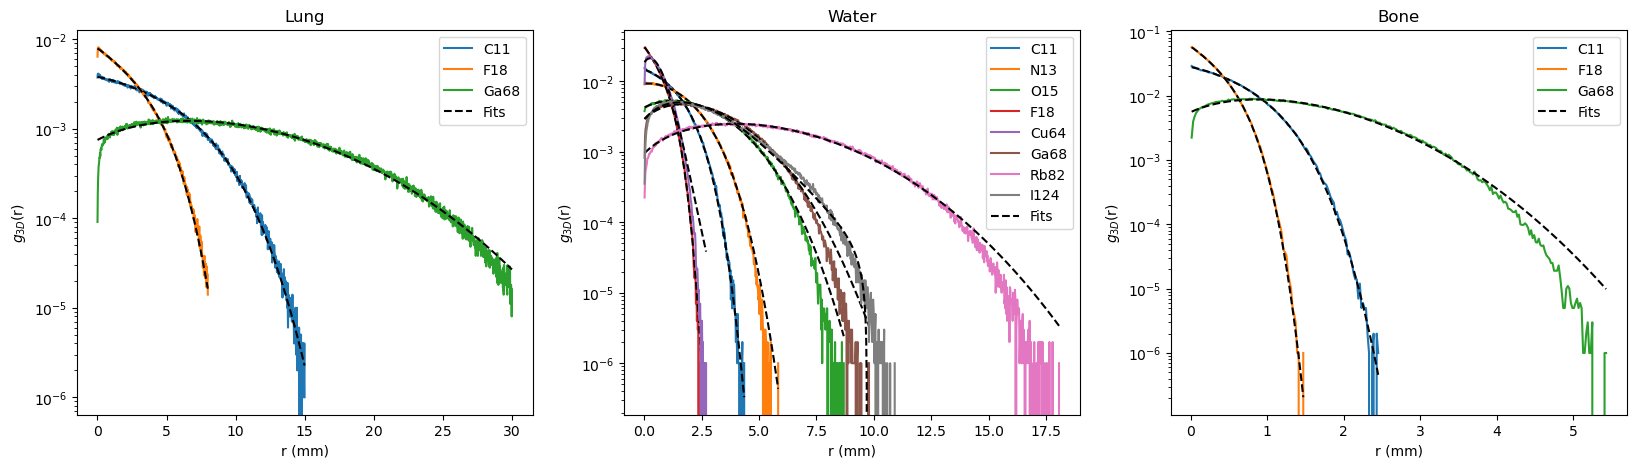

**********-PenEasy2024_xyz-**********
Lung - C11          	res=0.8633	chi2=8.4031
Lung - F18          	res=0.4724	chi2=5.5781
Lung - Ga68         	res=2.9536	chi2=114.6096
Water - C11         	res=0.9730	chi2=10.7829
Water - N13         	res=0.2881	chi2=0.7194
Water - O15         	res=0.5639	chi2=1.8737
Water - F18         	res=0.6111	chi2=6.2415
Water - Cu64        	res=4.8966	chi2=310.3635
Water - Ga68        	res=2.7810	chi2=109.7563
Water - Rb82        	res=1.9929	chi2=57.7165
Water - I124        	res=4.9776	chi2=297.0847
Bone - C11          	res=0.7794	chi2=6.3696
Bone - F18          	res=0.6649	chi2=6.7970
Bone - Ga68         	res=2.9359	chi2=118.3843


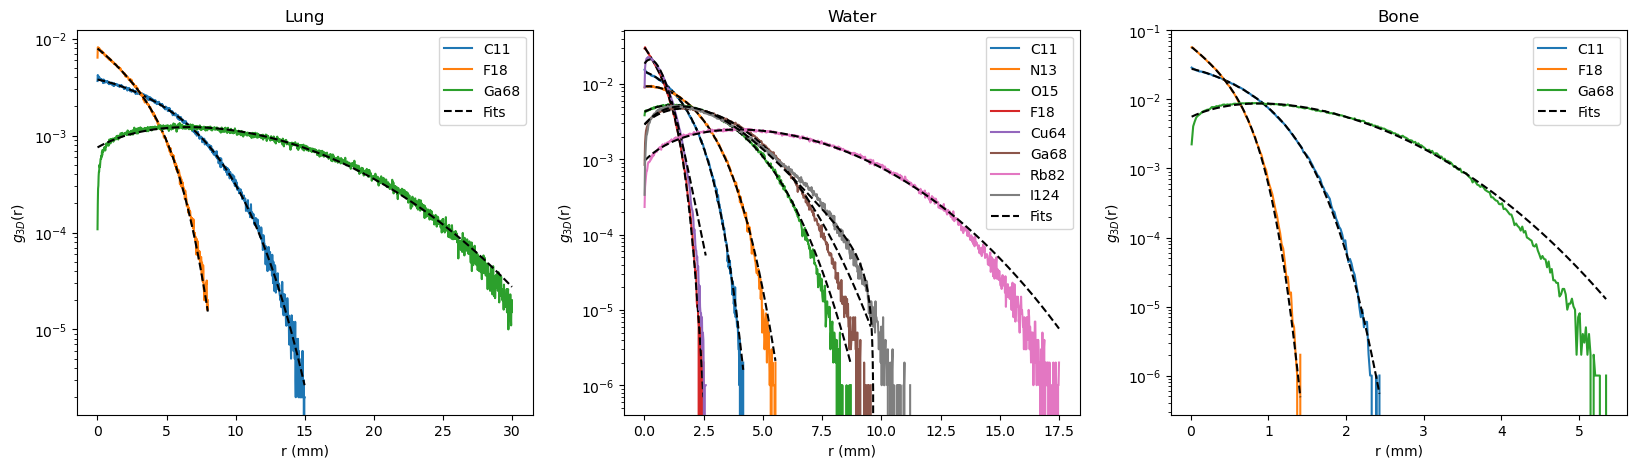

**********-PeneloPET2024_xyz-**********
Lung - C11          	res=0.7436	chi2=10.5468
Lung - F18          	res=0.6984	chi2=22.5667
Lung - Ga68         	res=3.0150	chi2=145.1439
Water - C11         	res=0.7310	chi2=11.0102
Water - N13         	res=0.4569	chi2=8.9883
Water - O15         	res=1.0403	chi2=19.0494
Water - F18         	res=0.7839	chi2=21.7711
Water - Cu64        	res=0.7839	chi2=21.7711
Water - Ga68        	res=3.1131	chi2=149.1536
Water - Rb82        	res=2.3656	chi2=96.1070
Water - I124        	res=3.7979	chi2=252.9497
Bone - C11          	res=0.7358	chi2=10.8002
Bone - F18          	res=0.7551	chi2=24.7845
Bone - Ga68         	res=3.2949	chi2=164.9079


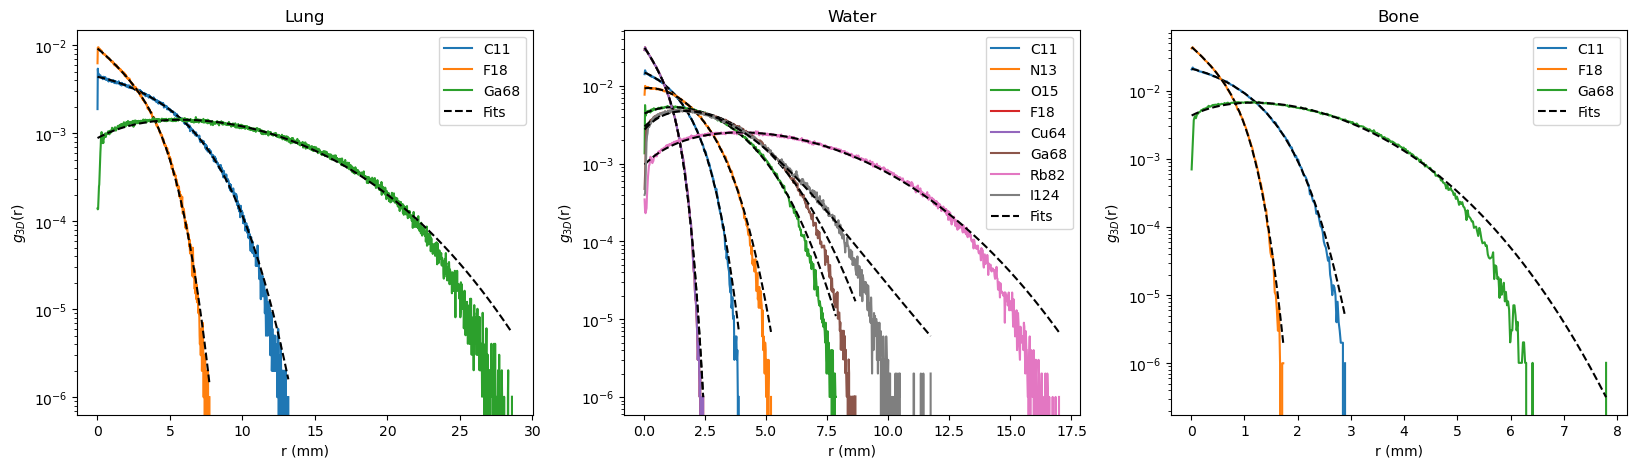

**********-GATE92_xyz-**********
Lung - C11          	res=3.3594	chi2=132.6537
Lung - F18          	res=3.5141	chi2=72.5175
Lung - Ga68         	res=3.5288	chi2=131.5423
Water - C11         	res=2.4606	chi2=52.9977
Water - N13         	res=1.3509	chi2=23.8486
Water - O15         	res=1.4324	chi2=14.7488
Water - F18         	res=2.2553	chi2=87.7360
Water - Cu64        	res=5.3409	chi2=419.5581
Water - Ga68        	res=1.2466	chi2=43.5224
Water - Rb82        	res=2.1222	chi2=31.7524
Water - I124        	res=3.2070	chi2=178.8707
Bone - C11          	res=2.4533	chi2=56.6793
Bone - F18          	res=3.0038	chi2=193.2479
Bone - Ga68         	res=2.5040	chi2=92.2233


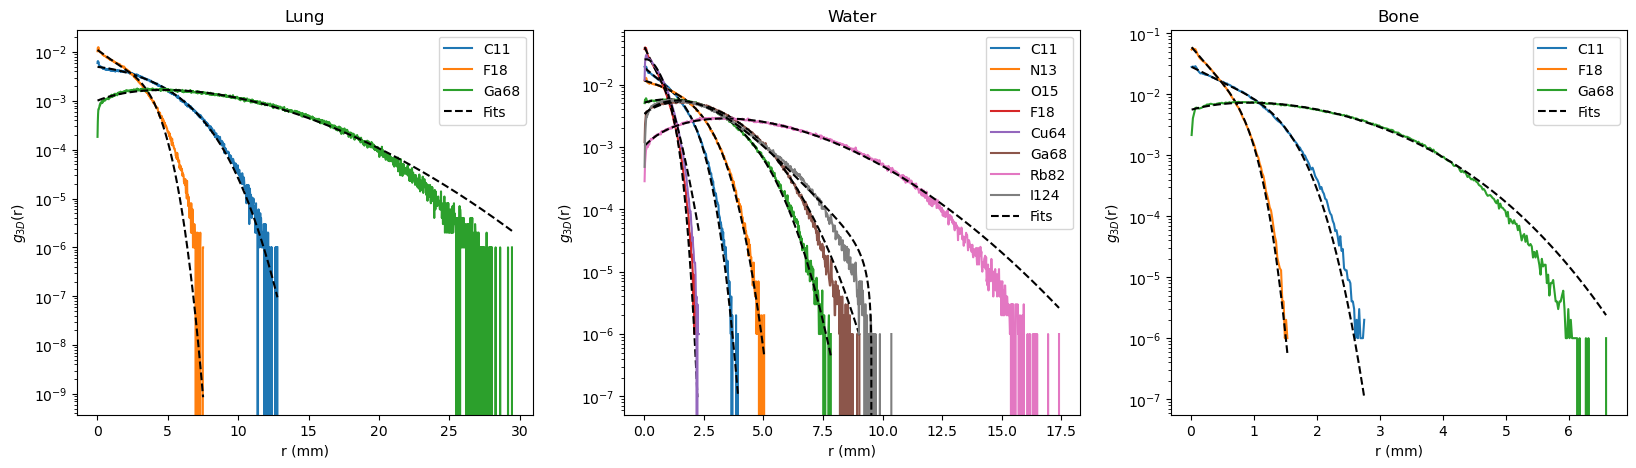

**********-GATE93_xyz-**********
Lung - C11          	res=3.3577	chi2=128.6793
Lung - F18          	res=3.4406	chi2=75.7587
Lung - Ga68         	res=3.6474	chi2=138.3385
Water - C11         	res=2.6238	chi2=56.5844
Water - N13         	res=1.5201	chi2=26.3009
Water - O15         	res=1.3708	chi2=13.5669
Water - F18         	res=2.3661	chi2=92.3413
Water - Cu64        	res=5.2526	chi2=412.4693
Water - Ga68        	res=1.2364	chi2=42.2643
Water - Rb82        	res=1.9397	chi2=28.4250
Water - I124        	res=3.0477	chi2=170.2649
Bone - C11          	res=2.1895	chi2=50.5521
Bone - F18          	res=3.0006	chi2=194.0440
Bone - Ga68         	res=2.7209	chi2=100.9679


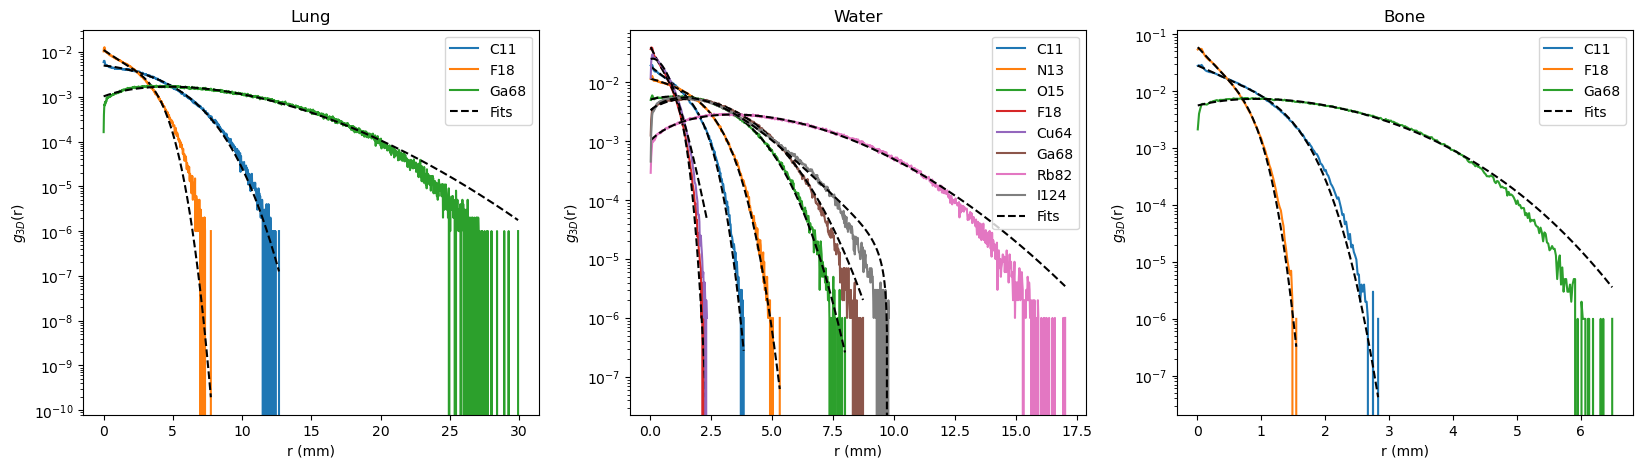

**********-GATE7_xyz-**********
Lung - C11          	res=3.3014	chi2=149.9412
Lung - F18          	res=4.2882	chi2=228.5579
Water - C11         	res=4.1035	chi2=180.6546
Water - O15         	res=2.3424	chi2=82.4891
Water - F18         	res=6.0491	chi2=258.1139
Bone - C11          	res=5.4883	chi2=246.6801
Bone - F18          	res=7.6923	chi2=449.3133


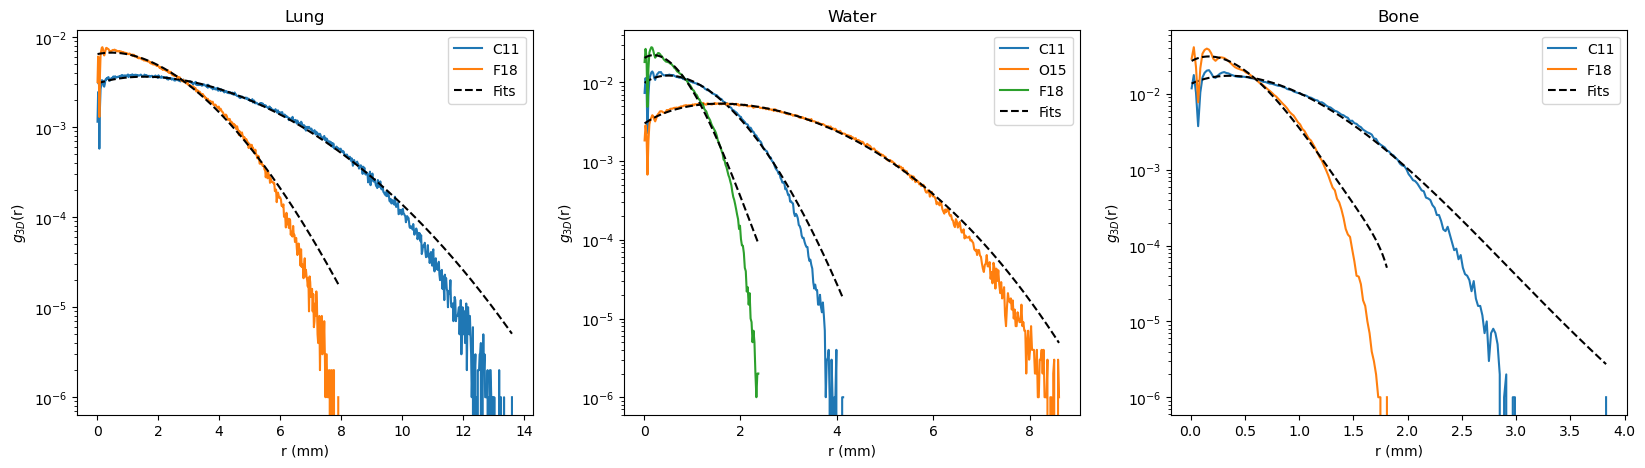

In [8]:
cfolders = {
    "PHITS_xyz":"PHITS",
    "PenEasy2020_xyz":"SPC",
    "PenEasy2024_xyz":"SPC",
    "PeneloPET2024_xyz":"2024",
    "GATE92_xyz":"9",
    "GATE93_xyz":"9",
    "GATE7_xyz":"7",
}
materials = ["Lung", "Water", "Bone"]
isotopes = ["C11", "N13", "O15", "F18", "Cu64", "Ga68", "Rb82", "I124"]
bs = 2e-3      #cm

# Defining fitting function
args = [a,b,c]
args0 = [1,1,1]
spf = lambda x, a,b,c: 1 - sp.exp(-(a*x + b*x**2  + c*x**4))
fit_func = FitG3D(spf, args, args0, '1 - exp(-(a*x + b*x^2  + c*x^4))')


for cfolder, pid in cfolders.items():
    print(f"**********-{cfolder}-**********")
    plt.figure(figsize=(20,5))
    for k,mat in enumerate(materials,1):
        plt.subplot(1,3,k)
        save_file = f"RESULTS/SPC/{mat}/{cfolder}/{pid}_fitParams.txt"
        save_txt = f"# Fitting function: {fit_func.name}\n"
        save_txt += f"# {'Isotope':<7} {'residual':<8} {'chi2':<7} {'a':<6} {'b':<6} {'c':<6}\n"
        for iso in isotopes:
            if mat in ["Lung", "Bone"] and iso not in ["C11", "F18", "Ga68"]: continue
            if cfolder == "GATE7_xyz" and iso not in ["C11", "O15", "F18"]: continue
            
            # Load sample
            input_file = f"../PRcomp/RESULTS/SPC/{mat}/{cfolder}/{iso}.dat" # in cm
            sample_r, sample_G3D = load_G3D(input_file)
            sample_rp, sample_g3D = load_g3D(input_file, bin_size=bs)
            sample_r *= 10
            sample_rp *= 10

            # Fit
            res, chi2 = fit_func.fit(sample_r, sample_G3D)
            print(f"{' - '.join([mat, iso]):<20}\t{res=:.4f}\t{chi2=:.4f}")
            # fit_func.show_info(redon=4)
            fit_G3D = fit_func.get_G3D()
            fit_g3D = fit_func.get_g3D()

            # Plot
            # plt.plot(sample_r, sample_G3D, label=f'{iso}')
            # plt.plot(sample_r, fit_G3D(sample_r), 'k--', label='')
            plt.plot(sample_rp, sample_g3D, label=f'{iso}')
            plt.plot(sample_rp, (gg:=fit_g3D(sample_rp))/gg.sum(), 'k--', label='')

            # Save fit parameters
            params_rounded, _ = fit_func.get_params(redon=3)
            pa, pb, pc = params_rounded
            save_txt += f"{iso:<7} {res:8.3f} {chi2:8.3f} {pa:6.3f} {pb:6.3f} {pc:6.3f}\n"

        plt.plot([], [], 'k--', label='Fits')
        plt.xlabel('r (mm)')
        plt.ylabel(r'$g_{3D}$(r)')
        #plt.xscale('log')
        plt.yscale('log')
        #plt.xlim(1e-3, None)
        plt.title(f'{mat}')
        plt.legend()

        # Save fit parameters for given material and pid
        with open(save_file, 'w') as f:
            f.write(save_txt)
    plt.show()